In [1]:
import argparse
import torch.nn.functional as F
import torch
from torch import tensor
from network import Net1, TransferNet
import numpy as np
from utils import load_data, coarsening, create_distribution_tensor
import os
from tqdm import tqdm
import time
from torch_geometric.loader import DataLoader

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default='cora')
parser.add_argument('--experiment', type=str, default='fixed') #'fixed', 'random', 'few'
parser.add_argument('--runs', type=int, default=20)
parser.add_argument('--hidden', type=int, default=512)
parser.add_argument('--epochs1', type=int, default=50)
parser.add_argument('--epochs2', type=int, default=100)
parser.add_argument('--num_layers1', type=int, default=2)
parser.add_argument('--num_layers2', type=int, default=2)
parser.add_argument('--batch_size', type=int, default=128)
parser.add_argument('--early_stopping', type=int, default=10)
parser.add_argument('--extra_node', type=bool, default=False)
parser.add_argument('--lr', type=float, default=0.01)
parser.add_argument('--weight_decay', type=float, default=0.0005)
parser.add_argument('--normalize_features', type=bool, default=True)
parser.add_argument('--coarsening_ratio', type=float, default=0.1)
parser.add_argument('--coarsening_method', type=str, default='algebraic_JC') #'variation_neighborhoods', 'variation_edges', 'variation_cliques', 'heavy_edge', 'algebraic_JC', 'affinity_GS', 'kron'
#parser.add_argument('--output_dir', type=str, required=True)

_StoreAction(option_strings=['--coarsening_method'], dest='coarsening_method', nargs=None, const=None, default='algebraic_JC', type=<class 'str'>, choices=None, help=None, metavar=None)

In [3]:
import sys
sys.argv = ['']

In [4]:
args = parser.parse_args()

In [5]:
args.num_features, args.num_classes, candidate, C_list, Gc_list, subgraph_list = coarsening(args, 1-args.coarsening_ratio, args.coarsening_method)
print('num_features: {}, num_classes: {}'.format(args.num_features, args.num_classes))
print('Number of components: {}'.format(len(candidate)))

Subgraphs created, number of subgraphs:  441
num_features: 1433, num_classes: 7
Number of components: 78


In [6]:
subgraph_list[0]

Data(
  x=[4, 1433],
  edge_index=[2, 4],
  y=[4],
  train_mask=[4],
  val_mask=[4],
  test_mask=[4],
  num_classes=7,
  map_dict={
    0=0,
    383=1,
    1862=2,
    2268=3
  },
  ext_node=[0]
)

In [7]:
coarsen_features, coarsen_train_labels, coarsen_train_mask, coarsen_val_labels, coarsen_val_mask, coarsen_edge, graphs = load_data(args.dataset, candidate, C_list, Gc_list, args.experiment, subgraph_list)
graph_data = DataLoader(graphs, batch_size=1, shuffle=True)  

the size of coarsen graph features: torch.Size([362, 1433])


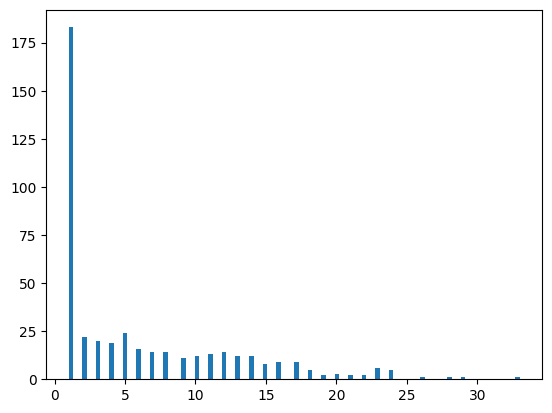

2708


In [8]:
#plot thehistogram of the number of nodes in each subgraph_list
import matplotlib.pyplot as plt
plt.hist([subgraph.num_nodes for subgraph in graph_data], bins=100)
plt.show()
print(sum([subgraph.num_nodes for subgraph in graph_data]))


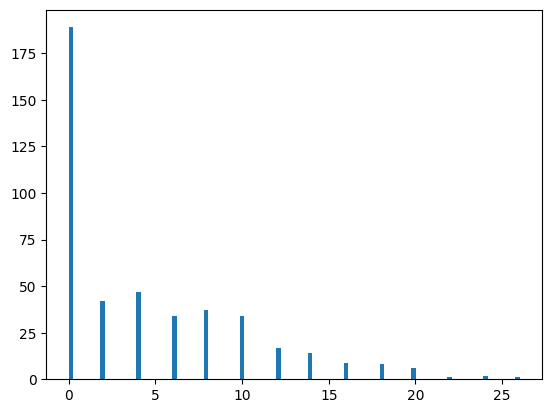

2016


In [9]:
import matplotlib.pyplot as plt
plt.hist([subgraph.num_edges for subgraph in graph_data], bins=100)
plt.show()
print(sum([subgraph.num_edges for subgraph in graph_data]))